In [2]:
!pip install tensorflow_text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 31.7 MB/s eta 0:00:00


In [3]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [4]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/spam.csv')
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [8]:
df.groupby('Category').describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    641  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

In [9]:
df['Category'].value_counts()

ham     4825
spam     747
Name: Category, dtype: int64

In [10]:
747/4825

0.15481865284974095

15% spam emails, 85% ham emails: This indicates class imbalance

In [11]:
df_spam = df[df['Category'] == 'spam']
df_spam.shape

(747, 2)

In [16]:
df_ham = df[df['Category'] == 'ham']
df_ham.shape

(4825, 2)

In [17]:
df_ham_downsampled = df_ham.sample(df_spam.shape[0])
df_ham_downsampled.shape

(747, 2)

In [18]:
df_balanced = pd.concat([df_ham_downsampled, df_spam])
df_balanced.shape

(1494, 2)

In [19]:
747*2

1494

In [20]:
df_balanced['Category'].value_counts()

ham     747
spam    747
Name: Category, dtype: int64

In [21]:
df_balanced['spam'] = df['Category'].apply(lambda x:1 if x == 'spam' else 0)
df_balanced.sample(5)

,Category,Message,spam
1848,spam,FREE NOKIA Or Motorola with upto 12mths 1/2pri...,1
2352,spam,Download as many ringtones as u like no restri...,1
1500,spam,"SMS. ac JSco: Energy is high, but u may not kn...",1
5342,spam,u r subscribed 2 TEXTCOMP 250 wkly comp. 1st w...,1
5222,ham,5 nights...We nt staying at port step liao...T...,0


In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_balanced['Message'], df_balanced['spam'], stratify=df_balanced['spam'])

In [23]:
X_train.head()

5242                                  Hmm thinking lor...
2455         Left dessert. U wan me 2 go suntec look 4 u?
2153    Hi kindly give us back our documents which we ...
349     Fancy a shag? I do.Interested? sextextuk.com t...
4514    Money i have won wining number 946 wot do i do...
Name: Message, dtype: object

Now lets import BERT model and get embeding vectors for few sample statements

In [24]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [26]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

get_sentence_embeding([
    "500$ discount. hurry up", 
    "Bhavin, are you up for a volleybal game tomorrow?"]
)

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.8435169 , -0.51327264, -0.88845724, ..., -0.74748874,
        -0.75314736,  0.91964483],
       [-0.8720836 , -0.5054398 , -0.9444668 , ..., -0.85847515,
        -0.7174535 ,  0.88082975]], dtype=float32)>

Get embeding vectors for few sample words. Compare them using cosine similarity

In [27]:
e = get_sentence_embeding([
    "banana", 
    "grapes",
    "mango",
    "jeff bezos",
    "elon musk",
    "bill gates"
]
)

In [28]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity([e[0]], [e[1]])

array([[0.9911088]], dtype=float32)

Values near to 1 means they are similar. 0 means they are very different. Above you can use comparing "banana" vs "grapes" you get 0.99 similarity as they both are fruits

In [29]:
cosine_similarity([e[0]],[e[3]])

array([[0.84703845]], dtype=float32)

In [30]:
cosine_similarity([e[3]],[e[4]])

array([[0.9872034]], dtype=float32)

Jeff bezos and Elon musk are more similar then Jeff bezos and banana as indicated above

In [31]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [32]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

In [33]:
len(X_train)

1120

In [34]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [35]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
35/35 [==============================] - 534s 15s/step - loss: 0.6179 - accuracy: 0.6732 - precision: 0.6816 - recall: 0.6500
Epoch 2/10
35/35 [==============================] - 545s 16s/step - loss: 0.5042 - accuracy: 0.8036 - precision: 0.8047 - recall: 0.8018
Epoch 3/10
35/35 [==============================] - 525s 15s/step - loss: 0.4262 - accuracy: 0.8545 - precision: 0.8336 - recall: 0.8857
Epoch 4/10
35/35 [==============================] - 515s 15s/step - loss: 0.3958 - accuracy: 0.8643 - precision: 0.8529 - recall: 0.8804
Epoch 5/10
35/35 [==============================] - 520s 15s/step - loss: 0.3589 - accuracy: 0.8768 - precision: 0.8676 - recall: 0.8893
Epoch 6/10
35/35 [==============================] - 522s 15s/step - loss: 0.3372 - accuracy: 0.8848 - precision: 0.8696 - recall: 0.9054
Epoch 7/10
35/35 [==============================] - 512s 15s/step - loss: 0.3170 - accuracy: 0.8991 - precision: 0.8847 - recall: 0.9179
Epoch 8/10
35/35 [=======================

In [36]:
model.evaluate(X_test, y_test)

12/12 [==============================] - 171s 14s/step - loss: 0.2418 - accuracy: 0.9332 - precision: 0.9451 - recall: 0.9198


[0.2417750060558319,
 0.9331550598144531,
 0.9450549483299255,
 0.9197860956192017]

In [ ]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

In [38]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0,
       1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0,
       0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1,
       1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1,
       0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1,
       0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0,

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm

Text(50.722222222222214, 0.5, 'Truth')

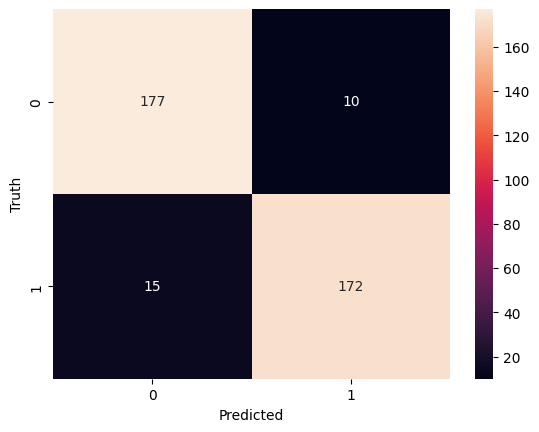

In [40]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [41]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.92      0.95      0.93       187
           1       0.95      0.92      0.93       187

    accuracy                           0.93       374
   macro avg       0.93      0.93      0.93       374
weighted avg       0.93      0.93      0.93       374



In [42]:
reviews = [
    'Enter a chance to win $5000, hurry up, offer valid until march 31, 2021',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your ."
]
model.predict(reviews)

1/1 [==============================] - 3s 3s/step


array([[0.65606576],
       [0.7932789 ],
       [0.7274735 ],
       [0.180406  ],
       [0.09623666]], dtype=float32)